# E14 폐렴 진단


## 들어가기 전에 

데이터 출저: 캐글 Chest X-Ray images 

[Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

``` terminal
$ mkdir -p ~/aiffel/chest_xray
$ cd ~/Downloads && unzip archive.zip -d ~/aiffel
```

### 사전 정보

의료 영상 촬영의 세 단면

* Sagittal plane : 시상면. 사람을 왼쪽과 오른쪽을 나누는 면.

* Coronal plane : 관상면. 인체를 앞 뒤로 나누는 면.

* Transverse plane : 횡단면(수평면). 인체를 상하로 나누는 면.

[폐렴 위키디피아](https://ko.wikipedia.org/wiki/%ED%8F%90%EB%A0%B4)

[염증 위키디피아](https://ko.wikipedia.org/wiki/%EC%97%BC%EC%A6%9D)

## Set-up

### library

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지
import seaborn as sns # 시각화 패키치 

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/ssac4/aiffel


### load data

In [82]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


원 validation 데이터가 너무 적어서 train에서 일부 뽑아서 분할합니다.

In [84]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


### 전처리와 시각화

train 데이터 안의 정상 이미지와 폐렴 이미지 수 체크 

In [85]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1061
Pneumonia images count in training set: 3124


/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

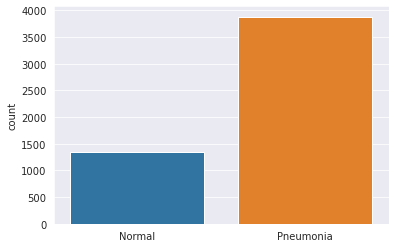

In [86]:
l = []
for filename in filenames:
    if( "PNEUMONIA" in filename):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)        

정상보다 폐렴 이미지가 3배 많습니다. 

In [87]:
train_list_ds  = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

 tf.data을 통해 배치 처리 작업을 효율적으로 할 수 있습니다. 

In [88]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()

print("Training images count: " + str(TRAIN_IMG_COUNT))


VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


Train 데이터 셋, validation 데이터 셋 갯수 확인

In [89]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


라벨 이름들을 한번 확인해보겠습니다.

현재 데이터에 라벨 데이터가 없기 때문에 라벨 데이터 만드는 함수를 만들어 보았습니다.

In [90]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

이미지 데이터는 사이즈가 제각각이기 때문에 이미지 사이즈를 맞춰주는 decode_img와 proecess_path 함수 생성합니다.

In [91]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [92]:
train_ds = train_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)

num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE 이용시 빠른 데이터 처리 가능합니다.

In [93]:
for image, label in train_ds.take(4):
    print("image shape: ", image.numpy().shape)
    print("Label:", label.numpy())

image shape:  (180, 180, 3)
Label: False
image shape:  (180, 180, 3)
Label: True
image shape:  (180, 180, 3)
Label: True
image shape:  (180, 180, 3)
Label: False


작업이 잘 완료된것을 확인하였으며

test data에도 같은 작업을 진행합니다.

In [94]:
test_list_ds =  tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


prepare_for_training() 함수를 통해 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환합니다.

자세한 설명은 아래와 같습니다.

* shuffle() 고정 크기 버퍼 유지, 해당 버퍼에서 무작위로 균일하게 다음 요소 선택

* repeat() epoch를 진행하면서 repeat을 통해 데이터세을 여러번 사용할수 있게 맞춰줌

* batch() BATCH_SIZE에서 정한만큼 배치로 지정

* prefetch() 학습 데이터를 나눠 읽기 때문에 데이터를 GPU에서 학습중에 다음 데이터를 CPU에서 준비하여 리소스 효율화 가능

In [15]:
def prepare_for_training(ds, shuffle_buffer_size = 1000):
    
    ds = ds.shuffle(buffer_size = shuffle_buffer_size)
    
    ds = ds.repeat()
    
    ds = ds.batch(BATCH_SIZE)
    
    ds = ds.prefetch(buffer_size = AUTOTUNE)
    
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

전처리한 데이터를 시각화 해봅니다.

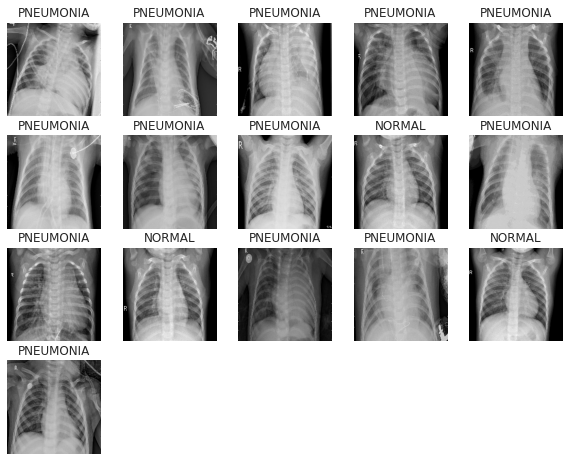

In [16]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10,10))
    for n in range(16):
        ax = plt.subplot(5,5, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
        
show_batch(image_batch.numpy(), label_batch.numpy())

# CNN 모델링

[개념 참고할만한 링크](http://taewan.kim/post/cnn/)



CNN Block

구성요소 - Convolution 2번 진행후 Bath Normalization을 통해 Gradient vanishing, Gradient Exploding 처리 그 후 Max Poooling 

In [98]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3 , activation = 'relu', padding = 'same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    
    return block
    

Dense Blcok 

구성 요소 - full connected layer 후 Bach Normalization 그후 지정한 만큼 Dropout

In [100]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

일반적으로 Batch Normailization과 Dropout을 동시에 사용하지않습니다.

**Batch Normalization**은 **variance shift**를 억제하지만 반대로 **Dropout** 은 **variance shift**를 유발하기 때문입니다.

참고 논문 
* [Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)       

반대로 **실무적으로 둘을 같이 쓰는것이 낫다**는 견해도 있습니다.           

참고논문 
* [Rethinking the Usage of Batch Normalization and Dropout in the Training of Deep Neural Networks](https://arxiv.org/pdf/1905.05928.pdf)

이번 분석에서는 일단 함께 사용한 후 추후에 변경하면서 정확도의 차이를 알아 보도록 하겠습니다.

In [101]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    return model

### 데이터 불균형 처리

classicfication 문제에서 한 종류의 데이터에 쏠려있으면 모델의 성능이 좋지않습니다.
이를 해결하기 위해서 Weight balancing을 사용하겠습니다.        
특정 데이터를 분류했을때의 loss를 더 큰 값을 주도록 가중치를 분류하는 것입니다.

[딥러닝에서 클래스 불균형을 다루는 방법](https://3months.tistory.com/414)

아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를,          
weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅합니다. 

이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정합니다.

In [102]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.97
Weight for class 1: 0.67


실습코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 

<!-- 추후에 이러한 처리를 생략하거나 또 recall을 강조하기 위해 폐렴데이터를 잘 맞추는 것을 더 강화하는 방법을 사용해보도록 하겠습니다. -->

### 모델 훈련

GPU를 통해 훈련함으로 GPU을 선택합니다. model은 위의 build_model()을 model에 선언합니다.

label은 2종류 이므로 binary cross entropy사용합니다.

optimaizer는 가장 일반적임 adam 사용합니다.

측정 metrics는 classificaion이므로 단순히 accuracy만을 보기보단 precision, recall 모두 사용합니다.

In [33]:
with tf.device('/GPU:0') :
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')
        
    ]
    
    model.compile(
        optimizer = 'adam',
        loss = 'binary_crossentropy',
        metrics = METRICS
    )

모델을 이제 학습합니다. 

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight)

Epoch 1/25
261/261 [==============================] - 27s 103ms/step - loss: 0.3930 - accuracy: 0.8068 - precision: 0.9526 - recall: 0.7785 - val_loss: 0.6726 - val_accuracy: 0.7413 - val_precision: 0.7413 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 23s 90ms/step - loss: 0.2128 - accuracy: 0.9143 - precision: 0.9760 - recall: 0.9068 - val_loss: 1.1338 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 24s 94ms/step - loss: 0.1974 - accuracy: 0.9284 - precision: 0.9795 - recall: 0.9231 - val_loss: 1.0946 - val_accuracy: 0.7413 - val_precision: 0.7413 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 24s 92ms/step - loss: 0.1688 - accuracy: 0.9363 - precision: 0.9810 - recall: 0.9322 - val_loss: 0.4879 - val_accuracy: 0.7875 - val_precision: 0.7765 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 23s 88ms/step - loss: 0.1820 - accuracy: 

In [ ]:
### 결과 확인과 시각화

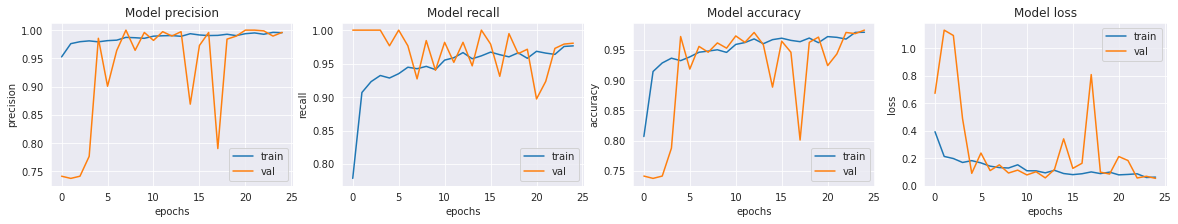

In [24]:
fig, ax = plt.subplots(1, 4 ,figsize = (20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision' , 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train','val'])

validation data에 대해서 값이 튀긴하지만 25 epoch에 다가가면서 점점 수렴함을 확인할 수 있었습니다.

모델 평가를 위해 test data에 대해서 loss, accuracy, precision, recall 값을 출력 해보겠습니다.

In [27]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 61ms/step - loss: 1.0722 - accuracy: 0.8189 - precision: 0.7787 - recall: 0.9923


test data에 대해서 약 82%의 accuracy, 78%의 precision, 99%의 recall을 확인 할 수 있었습니다.

## Ablation study 

regularzation, augmentation 등의 기법들을 사용할때와 하지않을때를 비교해보도록 하겠습니다.

### 모델링 변경

#### DROP OUT 제거

In [38]:
def dense_block_without_dropout(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

In [39]:
def build_model_without_dropout():
    model = tf.keras.Sequential([
        tf.keras.Input(shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
#         tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
#         tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_without_dropout(512, 0.7),
        dense_block_without_dropout(128, 0.5),
        dense_block_without_dropout(64, 0.3),
        
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    return model

dropout을 제외하고 모델을 적합시켜 보겠습니다.

In [45]:
with tf.device('/GPU:0') :
    model_without_dropout = build_model_without_dropout()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')
        
    ]
    
    model_without_dropout.compile(
        optimizer = 'adam',
        loss = 'binary_crossentropy',
        metrics = METRICS
    )

In [46]:
with tf.device('/GPU:0'):
    history_without_dropout = model_without_dropout.fit(
        train_ds,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight)

Epoch 1/25
261/261 [==============================] - 24s 93ms/step - loss: 0.2252 - accuracy: 0.9080 - precision: 0.9752 - recall: 0.8991 - val_loss: 0.6060 - val_accuracy: 0.7385 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 23s 90ms/step - loss: 0.1497 - accuracy: 0.9468 - precision: 0.9858 - recall: 0.9420 - val_loss: 1.0242 - val_accuracy: 0.7385 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 24s 91ms/step - loss: 0.1261 - accuracy: 0.9552 - precision: 0.9860 - recall: 0.9533 - val_loss: 0.1473 - val_accuracy: 0.9385 - val_precision: 0.9271 - val_recall: 0.9948
Epoch 4/25
261/261 [==============================] - 23s 88ms/step - loss: 0.1055 - accuracy: 0.9610 - precision: 0.9890 - recall: 0.9580 - val_loss: 0.1754 - val_accuracy: 0.9375 - val_precision: 0.9986 - val_recall: 0.9167
Epoch 5/25
261/261 [==============================] - 23s 89ms/step - loss: 0.1046 - accuracy: 0

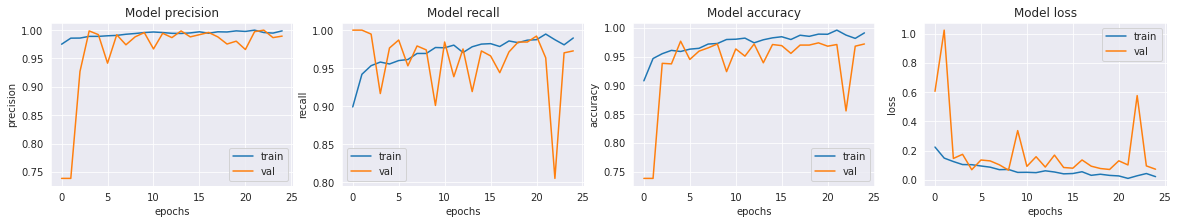

In [47]:
fig, ax = plt.subplots(1, 4 ,figsize = (20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision' , 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_without_dropout.history[met])
    ax[i].plot(history_without_dropout.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train','val'])

precision은 안정적이지만 recall과 accuracy는 상대적으로 변동이 심해서 모델의 수렴이 불안정함을 확인할 수 있습니다.

모델 평가를 위해 loss, accuracy, precision, recall 값을 출력 해보겠습니다.

In [48]:
loss, acc, prec, rec = model_without_dropout.evaluate(test_ds)

39/39 [==============================] - 2s 60ms/step - loss: 1.2985 - accuracy: 0.7532 - precision: 0.7218 - recall: 0.9846


결과 역시 accuracy, precision, recall 모두 하락함을 확인할 수 있었습니다.

#### Batch Normalization 제거

이번엔 반대로 Batch Normalization을 제거하고 학습을 진행해보겠습니다.

In [50]:
def dense_block_without_BN(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation = 'relu'),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

In [51]:
def conv_block_without_BN(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3 , activation = 'relu', padding = 'same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    
    return block
    

In [52]:
def build_model_without_BN():
    model = tf.keras.Sequential([
        tf.keras.Input(shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    return model

In [53]:
with tf.device('/GPU:0') :
    model_without_BN = build_model_without_BN()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')
        
    ]
    
    model_without_BN.compile(
        optimizer = 'adam',
        loss = 'binary_crossentropy',
        metrics = METRICS
    )

In [54]:
with tf.device('/GPU:0'):
    history_without_BN = model_without_BN.fit(
        train_ds,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight)

Epoch 1/25
261/261 [==============================] - 24s 90ms/step - loss: 0.3945 - accuracy: 0.8125 - precision: 0.9451 - recall: 0.7936 - val_loss: 0.7134 - val_accuracy: 0.7413 - val_precision: 0.7413 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 24s 90ms/step - loss: 0.2222 - accuracy: 0.9169 - precision: 0.9739 - recall: 0.9127 - val_loss: 1.4338 - val_accuracy: 0.7404 - val_precision: 0.7404 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 25s 94ms/step - loss: 0.2151 - accuracy: 0.9212 - precision: 0.9743 - recall: 0.9181 - val_loss: 0.2174 - val_accuracy: 0.9288 - val_precision: 0.9901 - val_recall: 0.9130
Epoch 4/25
261/261 [==============================] - 24s 92ms/step - loss: 0.1690 - accuracy: 0.9339 - precision: 0.9780 - recall: 0.9320 - val_loss: 0.2899 - val_accuracy: 0.8913 - val_precision: 0.9985 - val_recall: 0.8540
Epoch 5/25
261/261 [==============================] - 23s 89ms/step - loss: 0.1452 - accuracy: 0

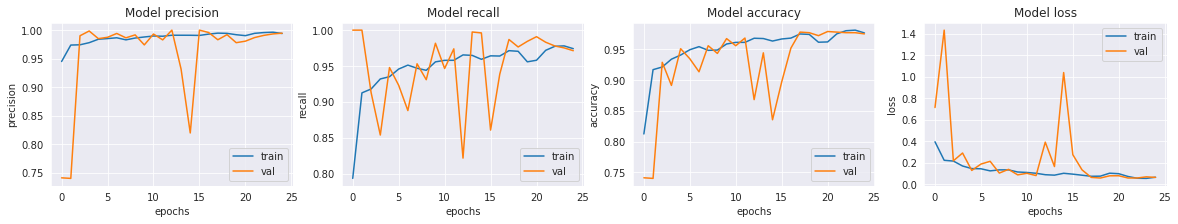

In [55]:
fig, ax = plt.subplots(1, 4 ,figsize = (20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision' , 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_without_BN.history[met])
    ax[i].plot(history_without_BN.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train','val'])

모델 평가를 위해 loss, accuracy, precision, recall 값을 출력 해보겠습니다.

In [56]:
loss, acc, prec, rec = model_without_BN.evaluate(test_ds)

39/39 [==============================] - 2s 59ms/step - loss: 0.9648 - accuracy: 0.8221 - precision: 0.7807 - recall: 0.9949


이전과 비교했을떄 accuracy, precision, recall이 소폭상승했음을 확인할 수 있었습니다. 
하지만 유의한 차이인지는 조금 더 검증을 해봐야할 것 같습니다.

(본래 모델 : accuracy: 0.8189 - precision: 0.7787 - recall: 0.9923)


### Data augmentaion 

의료 데이터는 수집이 어렵고 비용 역시 많이 듭니다. augmentaion을 통해서 데이터를 추가해보겠습니다.

단 의료 데이터에는 정밀성 역시 중요함으로 좌우 반전만 추가해보겠습니다.

In [95]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training_aug1(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training_aug1(train_ds)
val_ds = prepare_for_training_aug1(val_ds)


augment가 추가된 데이터를 통해서 모델을 적합시켜보겠습니다.

In [103]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight)

Epoch 1/25
261/261 [==============================] - 24s 92ms/step - loss: 0.1105 - accuracy: 0.9588 - precision: 0.9907 - recall: 0.9538 - val_loss: 0.3503 - val_accuracy: 0.8385 - val_precision: 1.0000 - val_recall: 0.7775
Epoch 2/25
261/261 [==============================] - 24s 90ms/step - loss: 0.0790 - accuracy: 0.9677 - precision: 0.9918 - recall: 0.9647 - val_loss: 0.0515 - val_accuracy: 0.9788 - val_precision: 0.9959 - val_recall: 0.9748
Epoch 3/25
261/261 [==============================] - 22s 85ms/step - loss: 0.0714 - accuracy: 0.9751 - precision: 0.9951 - recall: 0.9715 - val_loss: 0.0452 - val_accuracy: 0.9865 - val_precision: 0.9960 - val_recall: 0.9854
Epoch 4/25
261/261 [==============================] - 23s 89ms/step - loss: 0.0782 - accuracy: 0.9729 - precision: 0.9928 - recall: 0.9707 - val_loss: 0.1265 - val_accuracy: 0.9452 - val_precision: 0.9986 - val_recall: 0.9256
Epoch 5/25
261/261 [==============================] - 23s 90ms/step - loss: 0.0973 - accuracy: 0

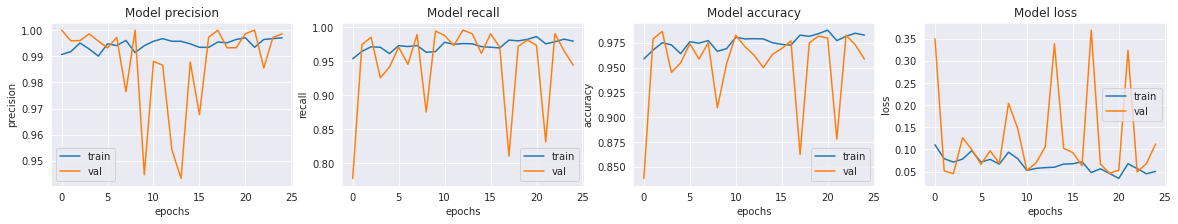

In [104]:
fig, ax = plt.subplots(1, 4 ,figsize = (20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision' , 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train','val'])

역시 augmentation을 추가하니 accurcay 자체는 더 상승하였습니다. 하지만 값의 변동이 상당히 큰 단점 역시 확인할 수 있었습니다. 

In [105]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 57ms/step - loss: 0.6482 - accuracy: 0.8622 - precision: 0.8423 - recall: 0.9590


test data에 대해서 accurcay 86%, precision 84% recall 95%를 기록하였습니다. recall 하락하였지만 그만큼 precision이 상승해서 전체적인 accuracy는 상승했음을 확인할 수 있습니다.

# 소고 

의료 데이터를 다뤄 본다는것 자체가 감회가 새로웠습니다.

이번 노드의 코드들이 다소 친절하다고 느껴졌고 공부하는데 많은 도움이 되었습니다.

data augmentation이라는 개념이 다소 신기했습니다.



 참고한 [캐글 노트북](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays)